# Prepare environment

In [1]:
import scanpy as sc, numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn.metrics as skm
import yaml

warnings.filterwarnings("ignore")

samples_map = {"CMO301": "CTL01A",
               "CMO302": "CTL02A",
               "CMO303": "CTL04E",
               "CMO304": "CTL08A",
               "CMO305": "CTL01A",
               "CMO306": "CTL02A",
               "CMO307": "CTL04E",
               "CMO308":"CTL08A",
               "Doublet": "Doublet",
               "Negative": "Negative",
               "Multiplet": "Doublet",
               "Unassigned": "Negative",
               
              }

old_names_map = {"809": "CTL04E",
                 "KOLF": "CTL08A",
                 "MIFF1": "CTL02A",
                 "3391B": "CTL01A",
                 "DBL": "Doublet",
                 "Doublet": "Doublet",
                 "unassigned": "Negative",
                 "Unassigned": "Negative",
                 "doublet": "Doublet",
                 "Multiplet": "Doublet",
                 "LowQuality": "Negative"
    
}


multiseq_gen_map = {"CMO301": "CTL01A",
                    "CMO302": "CTL02A",
                    "CMO303": "CTL04E",
                    "CMO304": "CTL08A",
                    "Doublet": "Doublet",
                    "Negative": "Negative" 
    
}

souporcell_map = {"0":"CTL08A",
                  "1":"CTL01A",
                  "2": "CTL02A",
                  "3": "CTL04E",
                  "doublet": "Doublet",
                  "unassigned": "Negative"
    
}

exposures_palette = {"CTL01A":"#DBB807",
                     "CTL08A":"#0FB248",
                     "CTL04E":"#FF0054",
                     "CTL02A":"#7B00FF",
                     "Doublet":"#403b3b",
                     "Negative":"#a8a5a5"
                    }

sd_palette = {"singlet":"#282f9c",
             "doublet":"#403b3b",
             "GoodQuality":"#29c429",
             "LowQuality":"#a8a5a5"}


colors_dict = {
"demux_v2_call": "blue",
"scansnp_call":"yellow",
"scansnp_w_neg": "orange",
"souporcell_call": "green",
"vireo_call":"red",
"Consensus":"cyan"
              }

order = list(exposures_palette.keys())

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.12
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


## Inputs folders

In [2]:
import os
homeDir = os.getenv("HOME")

MS_class = homeDir+"/data/cellplexDS/MultiSeqResults/118_2_Classification.csv"

genDem_folder = homeDir+"/data/cellplexDS/geneticDemultiplexing/results/class_tables/"

if not os.path.exists(homeDir+"/data/cellplexDS/adatas"):
   # Create a new directory because it does not exist
   os.makedirs(homeDir+"/data/cellplexDS/adatas")

## Initialize functions and objects

In [3]:
dbl_rate = {}
unassigned_rate = {}

# Load anndata
We load the raw matrix from `cellranger multi` and subset it according to the cell barcodes called as non-empty by the algorithm.

In [4]:
sample2_adata_raw = sc.read_10x_h5(homeDir+"/data/cellplexDS/alignment/test3_2/outs/multi/count/raw_feature_bc_matrix.h5")
sample2_adata_raw

reading /group/testa/Users/davide.castaldi/organoidMultiplexing_release/data/cellplexDS/alignment/test3_2/outs/multi/count/raw_feature_bc_matrix.h5


 (0:00:12)


AnnData object with n_obs × n_vars = 2807036 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
CR_class = pd.read_csv(homeDir+"/data/cellplexDS/alignment/test3_2/outs/multi/multiplexing_analysis/assignment_confidence_table.csv", index_col = "Barcodes")
CR_class

,Row,CMO301,CMO302,CMO303,CMO304,Multiplet,Blanks,Assignment,Assignment_Probability
Barcodes,,,,,,,,,
AAACCCAAGAGTGACC-1,0,9.999935e-01,1.779721e-11,2.950296e-11,1.428182e-17,6.350382e-06,1.440066e-07,CMO301,0.999994
AAACCCAAGCGCTGAA-1,1,9.999959e-01,3.114349e-13,8.816488e-12,1.162880e-17,4.100907e-06,4.303406e-08,CMO301,0.999996
AAACCCAAGGAACGAA-1,2,1.761102e-13,5.432238e-17,1.257945e-16,9.989698e-01,1.030235e-03,3.304961e-12,CMO304,0.998970
AAACCCAAGGCACTAG-1,3,1.303373e-20,1.659016e-18,3.766036e-17,9.999998e-01,2.034306e-07,3.738140e-12,CMO304,1.000000
AAACCCAAGGGTGAAA-1,4,3.318327e-20,6.775565e-06,1.920605e-07,1.709572e-23,9.999930e-01,2.515986e-14,Multiplet,0.999993
...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTCGAGTA-1,19549,2.069526e-25,8.458403e-22,5.723187e-12,1.869110e-06,9.999981e-01,2.068376e-19,Multiplet,0.999998
TTTGTTGTCTGCATAG-1,19550,1.958866e-20,2.616140e-18,8.355667e-16,9.999911e-01,8.914387e-06,1.817921e-12,CMO304,0.999991
TTTGTTGTCTGGGTCG-1,19551,4.487522e-14,9.999999e-01,3.075950e-15,9.693555e-20,1.150576e-08,8.057608e-08,CMO302,1.000000


In [6]:
sample2_adata = sample2_adata_raw[CR_class.index.tolist()]

# we save the "assignment_confidence_table.csv" in the obs so we have the assignment
sample2_adata.obs = CR_class

In [7]:
sample2_adata

AnnData object with n_obs × n_vars = 19554 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
sample2_adata.obs["Assignment"] = sample2_adata.obs["Assignment"].map(samples_map)
sample2_adata.obs["Assignment"].value_counts()

Assignment
CTL01A      4064
CTL08A      3759
CTL02A      3422
CTL04E      2837
Doublet     2331
Negative     559
Name: count, dtype: int64

In [9]:
# check if there are any nans in the Assignment column
CR_NaNs = sample2_adata[sample2_adata.obs["Assignment"].isna()].obs_names
len(CR_NaNs)

2582

In [10]:
sample2_adata.write(homeDir+"/data/cellplexDS/adatas/test3_2_raw.h5ad")
sample2_adata = sc.read(homeDir+"/data/cellplexDS/adatas/test3_2_raw.h5ad")

Now we load the filtered count matrix from the `cellranger count` alignment:

In [11]:
sample2_adata_count = sc.read_10x_h5(homeDir+"/data/cellplexDS/alignment/test3_2_count/outs/filtered_feature_bc_matrix.h5")
sample2_adata_count

reading /group/testa/Users/davide.castaldi/organoidMultiplexing_release/data/cellplexDS/alignment/test3_2_count/outs/filtered_feature_bc_matrix.h5
 (0:00:03)


AnnData object with n_obs × n_vars = 19911 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

`cellranger count` and `cellranger multi` don"t call exactly the same cells as non-empty, so I"m detecting how many cell barcodes are not in common:

In [12]:
len(set(sample2_adata_count.obs_names).difference(set(sample2_adata.obs_names)))

454

In [13]:
len(set(sample2_adata.obs_names).difference(set(sample2_adata_count.obs_names)))

97

I"m filtering out the few cells that are not called by both cellranger multi and cellranger count:

In [14]:
len(set(sample2_adata_count.obs_names).intersection(set(sample2_adata.obs_names)))

19457

In [15]:
sample2_adata = sample2_adata[list(set(sample2_adata_count.obs_names).intersection(set(sample2_adata.obs_names)).difference(set(CR_NaNs)))]
sample2_adata

View of AnnData object with n_obs × n_vars = 16875 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability'
    var: 'gene_ids', 'feature_types', 'genome'

## Evaluation of cellranger multi classification

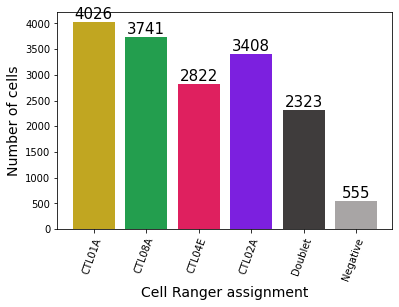

In [16]:
order_new = order.copy()
#order_new.remove("Negative")
#order_new.remove("Doublet")

fig, ax = plt.subplots()

sns.barplot(y = sample2_adata.obs.Assignment.value_counts().loc[order_new].values, ax = ax,
            x = sample2_adata.obs.Assignment.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = sample2_adata.obs.Assignment.value_counts().loc[order_new].index.to_list()
values = sample2_adata.obs.Assignment.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")

plt.xlabel("Cell Ranger assignment", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

Percentage of identities:

In [17]:
norm = sample2_adata.obs.Assignment.value_counts().loc[order_new] / sample2_adata.shape[0] * 100
norm

Assignment
CTL01A      23.857778
CTL08A      22.168889
CTL04E      16.722963
CTL02A      20.195556
Doublet     13.765926
Negative     3.288889
Name: count, dtype: float64

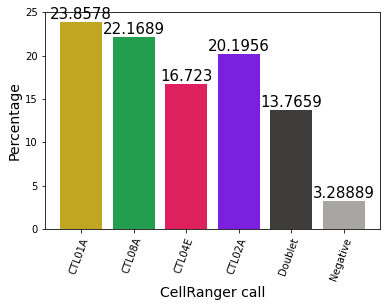

In [18]:
fig, ax = plt.subplots()

sns.barplot(y = norm.values, ax = ax,
            x = norm.index.to_list(), palette=exposures_palette)

labels = norm.index.to_list()
values = norm.values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("CellRanger call", size=14)
plt.ylabel("Percentage", size=14)
plt.show()

## Evaluation of MultiSeq classification

In [19]:
multi_seq_class_1 = pd.read_csv(MS_class, index_col = 0, sep = "\t")[["final.calls.rescued"]]
multi_seq_class_1.columns = ["MultiSeq_call"]
multi_seq_class_1.MultiSeq_call = multi_seq_class_1.MultiSeq_call.map(multiseq_gen_map)
multi_seq_class_1.MultiSeq_call.value_counts()

MultiSeq_call
CTL01A      4218
CTL08A      3848
CTL02A      3459
CTL04E      2845
Negative    2845
Doublet     2339
Name: count, dtype: int64

In [20]:
multi_seq_class_1.shape

(19554, 1)

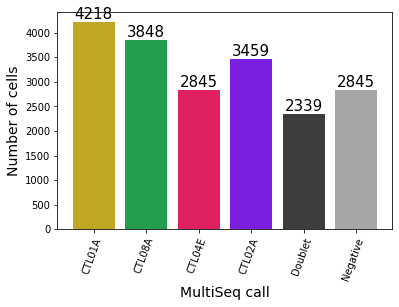

In [21]:
fig, ax = plt.subplots()

sns.barplot(y = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].values, ax = ax,
            x = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].index.to_list()
values = multi_seq_class_1.MultiSeq_call.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("MultiSeq call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

Percentages of identities

In [22]:
norm = multi_seq_class_1.MultiSeq_call.value_counts().loc[order] / multi_seq_class_1.shape[0] * 100
norm

MultiSeq_call
CTL01A      21.571034
CTL08A      19.678838
CTL04E      14.549453
CTL02A      17.689475
Doublet     11.961747
Negative    14.549453
Name: count, dtype: float64

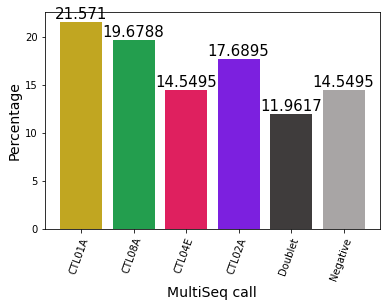

In [23]:
norm = multi_seq_class_1.MultiSeq_call.value_counts().loc[order] / multi_seq_class_1.shape[0] * 100
norm

fig, ax = plt.subplots()

sns.barplot(y = norm.values, ax = ax,
            x = norm.index.to_list(), palette=exposures_palette)

labels = norm.index.to_list()
values = norm.values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("MultiSeq call", size=14)
plt.ylabel("Percentage", size=14)
plt.show()

## Comparison of CellRanger and MultiSeq

In [24]:
df_all_class_sample2 = multi_seq_class_1.merge(sample2_adata.obs.Assignment, how = "inner", left_index = True, right_index = True)
df_all_class_sample2.columns = ["MultiSeq_call", "CellR_call"]
pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["CellR_call"])

CellR_call,CTL01A,CTL02A,CTL04E,CTL08A,Doublet,Negative
MultiSeq_call,,,,,,
CTL01A,4017,0,0,0,7,125
CTL02A,0,3371,0,0,5,68
CTL04E,0,0,2775,0,7,48
CTL08A,0,0,0,3731,3,80
Doublet,0,0,0,0,2301,30
Negative,9,37,47,10,0,204


## Genetic demultiplexing
In this section, we load and evaluate the results from each algorithm used in the aggregating pipeline

### Demuxlet v1

In [25]:
demuxlet_v1_sample2 = pd.read_csv(genDem_folder + "test03/demuxlet_v1/test03.best", sep = "\t", index_col = 0)
demuxlet_v1_sample2

,RD.TOTL,RD.PASS,RD.UNIQ,N.SNP,BEST,SNG.1ST,SNG.LLK1,SNG.2ND,SNG.LLK2,SNG.LLK0,...,DBL.2ND,ALPHA,LLK12,LLK1,LLK2,LLK10,LLK20,LLK00,PRB.DBL,PRB.SNG1
BARCODE,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAGTGACC-1,2497,170,147,122,DBL-3391B-809-0.500,3391B,-81.7533,809,-127.0830,-60.0636,...,809,0.5,-55.1575,-81.7533,-127.0830,-81.7533,-55.1575,-62.3446,1.000000e+00,1.000
AAACCCAAGCGCTGAA-1,4798,303,278,196,SNG-3391B,3391B,-103.6999,809,-262.0932,-93.6938,...,MIFF1,0.5,-115.4474,-103.6999,-489.0273,-103.6999,-115.4474,-95.2410,4.990000e-07,1.000
AAACCCAAGGAACGAA-1,5100,390,372,199,SNG-KOLF,KOLF,-99.1772,809,-407.5953,-107.2806,...,KOLF,0.5,-115.3596,-433.3590,-99.1772,-432.3696,-115.3596,-113.6137,7.720000e-09,1.000
AAACCCAAGGCACTAG-1,26839,1180,1060,582,SNG-KOLF,KOLF,-334.0105,809,-991.7026,-340.2659,...,KOLF,0.5,-336.5899,-991.7026,-334.0105,-788.4272,-346.7130,-339.1439,4.550000e-03,1.000
AAACCCAAGGGTGAAA-1,24559,1380,1274,818,DBL-809-MIFF1-0.500,809,-1072.1413,MIFF1,-1225.6515,-610.7208,...,MIFF1,0.5,-427.3709,-1072.1413,-1225.6515,-987.4368,-737.8058,-483.9193,1.000000e+00,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTCGAGTA-1,36661,1742,1630,983,DBL-809-KOLF-0.500,KOLF,-1041.5737,809,-1091.6427,-591.0111,...,KOLF,0.5,-450.5371,-1091.6427,-1041.5737,-901.5851,-708.4455,-519.4737,1.000000e+00,1.000
TTTGTTGTCTGCATAG-1,9788,758,719,466,SNG-KOLF,KOLF,-231.2384,809,-730.5278,-257.9244,...,KOLF,0.5,-261.4773,-730.5278,-231.2384,-592.0759,-272.3258,-266.1862,4.440000e-15,1.000
TTTGTTGTCTGGGTCG-1,24948,1003,941,556,SNG-MIFF1,MIFF1,-300.6162,809,-1329.9039,-370.7559,...,MIFF1,0.5,-389.4882,-1329.9039,-300.6162,-1104.1003,-395.9653,-377.6847,1.530000e-40,1.000


In [26]:
demuxlet_v1_sample2["doubletState"] = demuxlet_v1_sample2["BEST"].apply(lambda x: x.split("-")[0])
demuxlet_v1_sample2["doubletState"].value_counts()

doubletState
DBL    10071
SNG     9840
Name: count, dtype: int64

In [27]:
demuxlet_v1_sample2["demux_v1_call"] = demuxlet_v1_sample2["BEST"].apply(lambda x: x.split("-")[1] if "DBL" not in x else ("DBL"))
demuxlet_v1_sample2["demux_v1_call"].value_counts()

demux_v1_call
DBL      10071
MIFF1     2755
KOLF      2746
3391B     2237
809       2102
Name: count, dtype: int64

In [28]:
df_all_class_sample2 = df_all_class_sample2.merge(demuxlet_v1_sample2["demux_v1_call"], how = "inner", left_index = True, right_index = True)
df_all_class_sample2["demux_v1_call"] = df_all_class_sample2["demux_v1_call"].map(old_names_map)

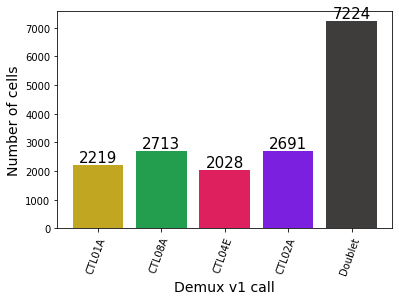

In [29]:
order_new = order.copy()
order_new.remove("Negative")

fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.demux_v1_call.value_counts().loc[order_new].values, ax = ax,
            x = df_all_class_sample2.demux_v1_call.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.demux_v1_call.value_counts().loc[order_new].index.to_list()
values = df_all_class_sample2.demux_v1_call.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Demux v1 call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='demux_v1_call', ylabel='MultiSeq_call'>

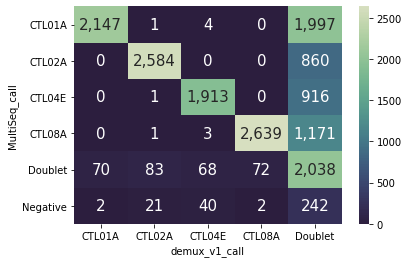

In [30]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["demux_v1_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='demux_v1_call', ylabel='CellR_call'>

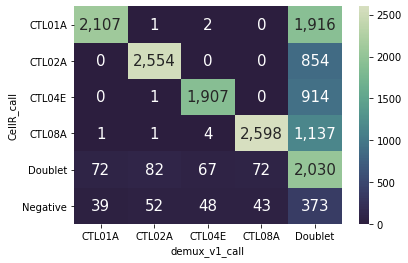

In [31]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["demux_v1_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Demuxlet v2

In [32]:
demuxlet_v2_sample2 = pd.read_csv(genDem_folder + "test03/demuxlet_v2/test03.best", sep = "\t", index_col = 1)
demuxlet_v2_sample2

,INT_ID,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.GUESS,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL
BARCODE,,,,,,,,,,,,,,,,,,,
AAACCCAAGAGTGACC-1,0,108,114,DBL,"3391B,809,0.50",-46.28,"809,3391B,0.50",-46.28,0.00,6.600000e-22,1,3391B,-50.01,809,-60.04,0.0,"3391B,809,0.50",-46.28,-3.73
AAACCCAAGCGCTGAA-1,1,178,223,SNG,"3391B,3391B,0.00",-74.07,"3391B,MIFF1,0.50",-83.48,9.41,-7.600000e+01,1,3391B,-74.07,809,-127.31,0.0,"3391B,MIFF1,0.50",-83.48,9.41
AAACCCAAGGAACGAA-1,2,178,324,SNG,"KOLF,KOLF,0.00",-68.37,"KOLF,MIFF1,0.50",-89.08,20.71,-7.000000e+01,1,KOLF,-68.37,809,-157.94,0.0,"KOLF,MIFF1,0.50",-89.08,20.71
AAACCCAAGGCACTAG-1,3,533,880,SNG,"KOLF,KOLF,0.00",-213.29,"KOLF,809,0.50",-254.48,41.19,-2.200000e+02,1,KOLF,-213.29,809,-405.42,0.0,"KOLF,809,0.50",-254.48,41.19
AAACCCAAGGGTGAAA-1,4,780,1100,DBL,"809,MIFF1,0.50",-382.68,"MIFF1,809,0.50",-382.68,0.00,5.300000e-168,1,MIFF1,-530.34,809,-544.93,0.0,"809,MIFF1,0.50",-382.68,-147.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTCGAGTA-1,19906,918,1345,DBL,"809,KOLF,0.50",-402.86,"KOLF,809,0.50",-402.86,0.00,9.200000e-177,1,KOLF,-529.50,809,-536.68,0.0,"809,KOLF,0.50",-402.86,-126.64
TTTGTTGTCTGCATAG-1,19907,440,647,SNG,"KOLF,KOLF,0.00",-174.49,"KOLF,809,0.50",-218.61,44.12,-1.800000e+02,1,KOLF,-174.49,809,-347.42,0.0,"KOLF,809,0.50",-218.61,44.12
TTTGTTGTCTGGGTCG-1,19908,522,747,SNG,"MIFF1,MIFF1,0.00",-216.51,"MIFF1,809,0.50",-279.00,62.49,-2.200000e+02,1,MIFF1,-216.51,809,-520.45,0.0,"MIFF1,809,0.50",-279.00,62.49


In [33]:
demuxlet_v2_sample2["demux_v2_call"] = [demuxlet_v2_sample2.loc[i, "DROPLET.TYPE"] if demuxlet_v2_sample2.loc[i, "DROPLET.TYPE"] == "DBL" else demuxlet_v2_sample2.loc[i, "SNG.BEST.GUESS"] for i in demuxlet_v2_sample2.index] 
demuxlet_v2_sample2["demux_v2_call"].value_counts()

demux_v2_call
DBL      5026
3391B    3997
KOLF     3964
MIFF1    3729
809      3195
Name: count, dtype: int64

In [34]:
# saving the doublets rate and unassigned rate
dbl_rate["Demuxlet"] = np.sum(demuxlet_v2_sample2["demux_v2_call"] == "DBL") / demuxlet_v2_sample2.shape[0]
dbl_rate

{'Demuxlet': 0.2524232836120737}

In [35]:
unassigned_rate["Demuxlet"] = 0
unassigned_rate

{'Demuxlet': 0}

In [36]:
df_all_class_sample2 = df_all_class_sample2.merge(demuxlet_v2_sample2["demux_v2_call"], how = "inner", left_index = True, right_index = True)
df_all_class_sample2["demux_v2_call"] = df_all_class_sample2["demux_v2_call"].map(old_names_map)

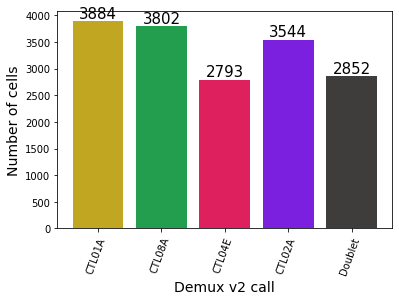

In [37]:
order_new = order.copy()
order_new.remove("Negative")

fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.demux_v2_call.value_counts().loc[order_new].values, ax = ax,
            x = df_all_class_sample2.demux_v2_call.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.demux_v2_call.value_counts().loc[order_new].index.to_list()
values = df_all_class_sample2.demux_v2_call.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Demux v2 call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='demux_v2_call', ylabel='MultiSeq_call'>

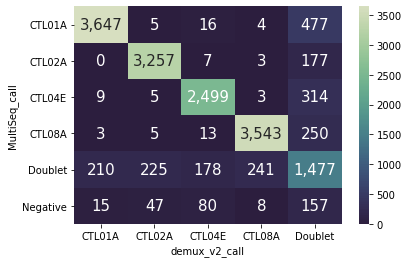

In [38]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["demux_v2_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='demux_v2_call', ylabel='CellR_call'>

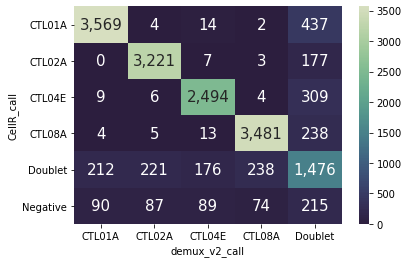

In [39]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["demux_v2_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### SCanSNP

In [40]:
scansnp_sample2 = pd.read_csv(genDem_folder + "test03/scansnp/Cell_IDs.tsv", sep = "\t", index_col = 0)
scansnp_sample2["scansnp_call"] = scansnp_sample2["ID"].map(old_names_map)
scansnp_sample2["scansnp_call_quality"] = scansnp_sample2["ID"].map(old_names_map) + "_" + scansnp_sample2["Quality"]
dbl_rate["SCanSNP"] = np.sum(scansnp_sample2["Quality"] == "Doublet") / scansnp_sample2.shape[0]
dbl_rate

{'Demuxlet': 0.2524232836120737, 'SCanSNP': 0.08532971724172568}

In [41]:
unassigned_rate["SCanSNP"] = 0
unassigned_rate

{'Demuxlet': 0, 'SCanSNP': 0}

In [42]:
df_all_class_sample2 = df_all_class_sample2.merge(scansnp_sample2["scansnp_call"], how = "inner", left_index = True, right_index = True)
df_all_class_sample2 = df_all_class_sample2.merge(scansnp_sample2["scansnp_call_quality"], how = "inner", left_index = True, right_index = True)
df_all_class_sample2 = df_all_class_sample2.merge(scansnp_sample2["Quality"], how = "inner", left_index = True, right_index = True)
df_all_class_sample2["scansnp_w_neg"] = np.where(df_all_class_sample2["Quality"] == "LowQuality", "Negative", df_all_class_sample2.scansnp_call)
df_all_class_sample2.shape

(16875, 8)

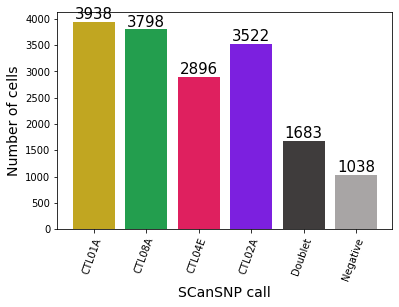

In [43]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.scansnp_w_neg.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample2.scansnp_w_neg.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.scansnp_w_neg.value_counts().loc[order].index.to_list()
values = df_all_class_sample2.scansnp_w_neg.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("SCanSNP call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

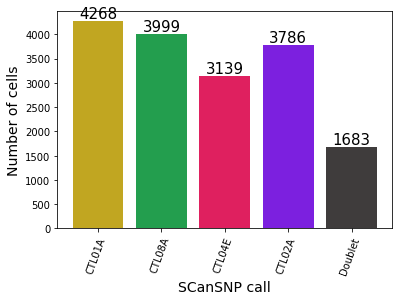

In [44]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.scansnp_call.value_counts().loc[order_new].values, ax = ax,
            x = df_all_class_sample2.scansnp_call.value_counts().loc[order_new].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.scansnp_call.value_counts().loc[order_new].index.to_list()
values = df_all_class_sample2.scansnp_call.value_counts().loc[order_new].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("SCanSNP call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

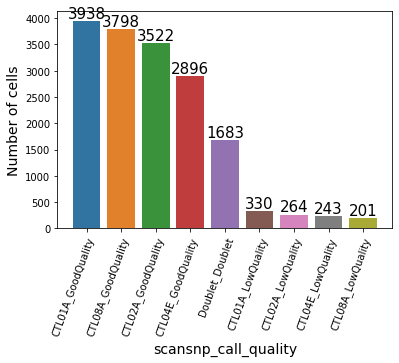

In [45]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.scansnp_call_quality.value_counts().values, ax = ax,
            x = df_all_class_sample2.scansnp_call_quality.value_counts().index.to_list())

labels = np.unique(df_all_class_sample2.scansnp_call_quality[~df_all_class_sample2.scansnp_call_quality.isna()])
values = df_all_class_sample2.scansnp_call_quality.value_counts().values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")

plt.xlabel("scansnp_call_quality", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

In [46]:
df_all_class_sample2["scansnp_call_lowquality"] = df_all_class_sample2["scansnp_call_quality"]

<AxesSubplot: xlabel='scansnp_w_neg', ylabel='MultiSeq_call'>

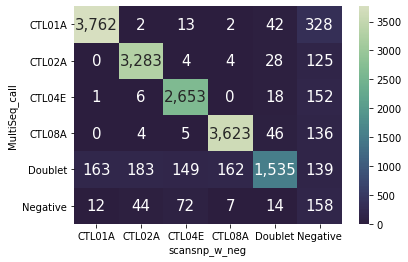

In [47]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["scansnp_w_neg"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='Quality', ylabel='MultiSeq_call'>

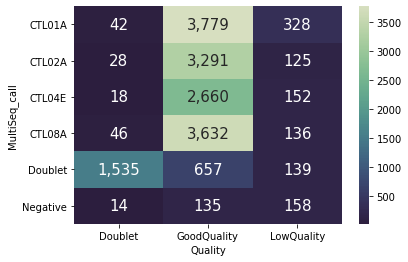

In [48]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["Quality"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='scansnp_w_neg', ylabel='CellR_call'>

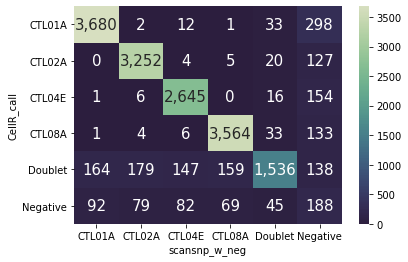

In [49]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["scansnp_w_neg"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='Quality', ylabel='CellR_call'>

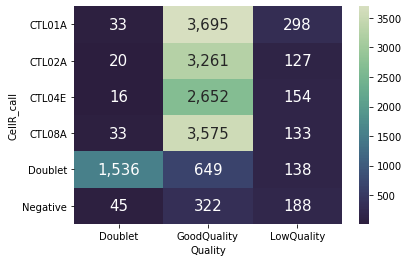

In [50]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["Quality"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Souporcell

In [51]:
souporcell_sample2 = pd.read_csv(genDem_folder + "test03/souporcell/clusters.tsv", sep = "\t", index_col = 0)
souporcell_sample2

,status,assignment,log_prob_singleton,log_prob_doublet,cluster0,cluster1,cluster2,cluster3
barcode,,,,,,,,
AAACCCAAGAGTGACC-1,singlet,1,-94.539711,-99.000540,-176.073017,-94.539711,-171.597895,-144.856476
AAACCCAAGCGCTGAA-1,singlet,1,-125.272316,-153.920586,-292.462476,-125.272316,-341.236606,-271.340643
AAACCCAAGGAACGAA-1,singlet,0,-84.585215,-105.321181,-84.585215,-215.010384,-255.421264,-205.977227
AAACCCAAGGCACTAG-1,singlet,0,-680.860332,-836.200867,-680.860332,-1493.182649,-1634.212687,-1428.794323
AAACCCAAGGGTGAAA-1,doublet,3/2,-1157.041834,-914.671492,-1647.553532,-1679.012200,-1267.481361,-1157.041834
...,...,...,...,...,...,...,...,...
TTTGTTGTCTCGAGTA-1,doublet,0/3,-1401.811624,-1179.781466,-1401.811624,-2035.652060,-2437.699703,-1551.429490
TTTGTTGTCTGCATAG-1,singlet,0,-255.317169,-324.149113,-255.317169,-668.818527,-841.477924,-641.782127
TTTGTTGTCTGGGTCG-1,singlet,2,-678.997565,-829.099954,-1581.471216,-1602.507805,-678.997565,-1534.956483


In [52]:
souporcell_sample2["souporcell_call"] = [souporcell_sample2.loc[i, "status"] if (souporcell_sample2.loc[i, "status"] == "doublet") or (souporcell_sample2.loc[i, "status"] == "unassigned") else souporcell_sample2.loc[i, "assignment"] for i in souporcell_sample2.index]
souporcell_sample2[["status", "souporcell_call"]].value_counts()

status      souporcell_call
singlet     1                  4315
            0                  4037
doublet     doublet            3890
singlet     2                  3719
            3                  3339
unassigned  unassigned          611
Name: count, dtype: int64

In [53]:
dbl_rate["SoC"] = np.sum(souporcell_sample2["status"] == "doublet") / souporcell_sample2.shape[0]
dbl_rate

{'Demuxlet': 0.2524232836120737,
 'SCanSNP': 0.08532971724172568,
 'SoC': 0.19536939380242077}

In [54]:
unassigned_rate["SoC"] = np.sum(souporcell_sample2["status"] == "unassigned") / souporcell_sample2.shape[0]
unassigned_rate

{'Demuxlet': 0, 'SCanSNP': 0, 'SoC': 0.030686555170508764}

In [55]:
df_all_class_sample2 = df_all_class_sample2.merge(souporcell_sample2["souporcell_call"].map(souporcell_map), how = "inner", left_index = True, right_index = True)

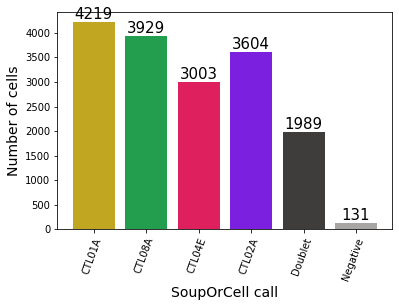

In [56]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.souporcell_call.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample2.souporcell_call.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.souporcell_call.value_counts().loc[order].index.to_list()
values = df_all_class_sample2.souporcell_call.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("SoupOrCell call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='souporcell_call', ylabel='MultiSeq_call'>

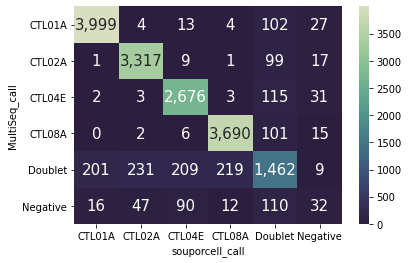

In [57]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["souporcell_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='souporcell_call', ylabel='CellR_call'>

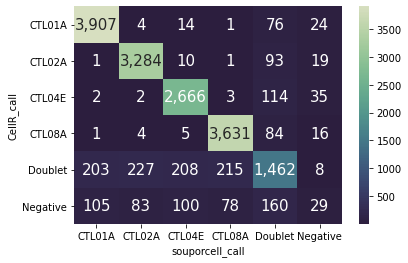

In [58]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["souporcell_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Vireo

In [59]:
vireo_sample2 = pd.read_csv(genDem_folder + "test03/vireo/vireo_out/donor_ids.tsv", sep = "\t", index_col = 0)
vireo_sample2

,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet
cell,,,,,,
AAACCCAAGAGTGACC-1,unassigned,4.260000e-01,5.740000e-01,65,3391B,"3391B,809"
AAACCCAAGCGCTGAA-1,3391B,1.000000e+00,1.520000e-07,147,3391B,"3391B,809"
AAACCCAAGGAACGAA-1,KOLF,1.000000e+00,1.180000e-15,145,KOLF,"809,3391B"
AAACCCAAGGCACTAG-1,KOLF,1.000000e+00,5.540000e-38,384,KOLF,"809,3391B"
AAACCCAAGGGTGAAA-1,doublet,9.990000e-100,1.000000e+00,496,809,"809,KOLF"
...,...,...,...,...,...,...
TTTGTTGTCTCGAGTA-1,doublet,7.040000e-52,1.000000e+00,629,KOLF,"809,3391B"
TTTGTTGTCTGCATAG-1,KOLF,1.000000e+00,3.260000e-32,307,KOLF,"809,3391B"
TTTGTTGTCTGGGTCG-1,MIFF1,1.000000e+00,1.070000e-81,373,MIFF1,"809,KOLF"


In [60]:
vireo_sample2["vireo_call"] = vireo_sample2["donor_id"].map(old_names_map)
vireo_sample2["vireo_call"].value_counts()

vireo_call
CTL01A      4082
CTL08A      3983
CTL02A      3703
Doublet     3246
CTL04E      3173
Negative    1724
Name: count, dtype: int64

In [61]:
dbl_rate["Vireo"] = np.sum(vireo_sample2["vireo_call"] == "Doublet") / vireo_sample2.shape[0]
dbl_rate

{'Demuxlet': 0.2524232836120737,
 'SCanSNP': 0.08532971724172568,
 'SoC': 0.19536939380242077,
 'Vireo': 0.16302546331173723}

In [62]:
unassigned_rate["Vireo"] = np.sum(vireo_sample2["vireo_call"] == "Negative") / vireo_sample2.shape[0]
unassigned_rate

{'Demuxlet': 0,
 'SCanSNP': 0,
 'SoC': 0.030686555170508764,
 'Vireo': 0.08658530460549445}

In [63]:
df_all_class_sample2 = df_all_class_sample2.merge(vireo_sample2["vireo_call"], how = "inner", left_index = True, right_index = True)

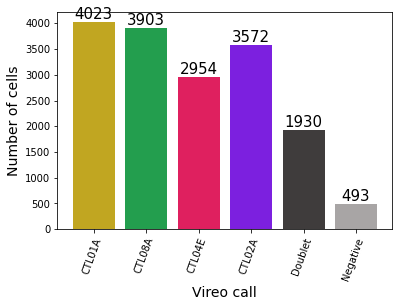

In [64]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.vireo_call.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample2.vireo_call.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.vireo_call.value_counts().loc[order].index.to_list()
values = df_all_class_sample2.vireo_call.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Vireo call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='vireo_call', ylabel='MultiSeq_call'>

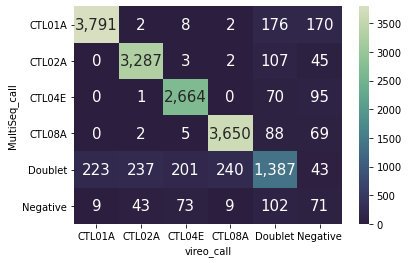

In [65]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["vireo_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='vireo_call', ylabel='CellR_call'>

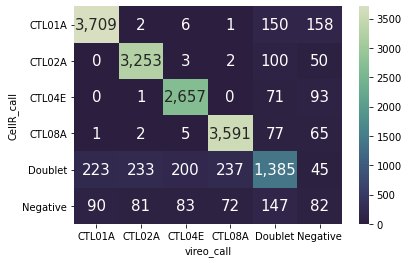

In [66]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["vireo_call"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### Dropkick

In [67]:
dropkick_sample2 = pd.read_csv(genDem_folder + "test03/dropkick/dropkick_class.tsv", sep = "\t", index_col = 0)
dropkick_sample2

,dropkick_label_03
barcode,
AAACCCAAGAGTGACC-1,LowQuality
AAACCCAAGCGCTGAA-1,LowQuality
AAACCCAAGGAACGAA-1,GoodQuality
AAACCCAAGGCACTAG-1,GoodQuality
AAACCCAAGGGTGAAA-1,GoodQuality
...,...
TTTGTTGTCTCGAGTA-1,GoodQuality
TTTGTTGTCTGCATAG-1,GoodQuality
TTTGTTGTCTGGGTCG-1,GoodQuality


In [68]:
dropkick_sample2["dropkick_label_03"].value_counts()

dropkick_label_03
GoodQuality    12914
LowQuality      6997
Name: count, dtype: int64

In [69]:
df_all_class_sample2 = df_all_class_sample2.merge(dropkick_sample2["dropkick_label_03"], how = "inner", left_index = True, right_index = True)

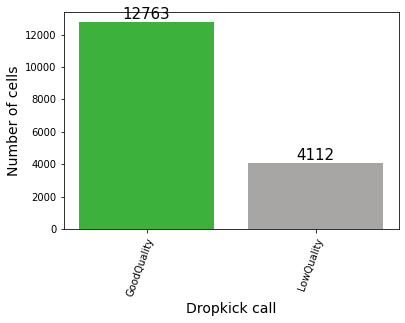

In [70]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.dropkick_label_03.value_counts().values, ax = ax,
            x = df_all_class_sample2.dropkick_label_03.value_counts().index.to_list(), palette=sd_palette)

labels = df_all_class_sample2.dropkick_label_03.value_counts().index.to_list()
values = df_all_class_sample2.dropkick_label_03.value_counts().values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Dropkick call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='dropkick_label_03', ylabel='MultiSeq_call'>

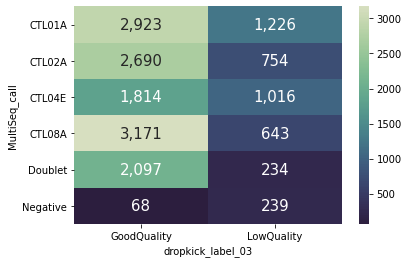

In [71]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["dropkick_label_03"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='dropkick_label_03', ylabel='CellR_call'>

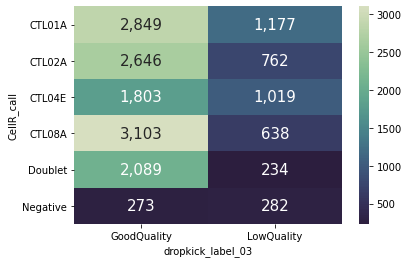

In [72]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["dropkick_label_03"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### scDblFinder

In [73]:
scdblfinder_sample2 = pd.read_csv(genDem_folder + "test03/scdblfinder/barcodesclass.tsv", sep = "\t", index_col = 0, header=None)
scdblfinder_sample2.columns = ["scdblfinder"]
scdblfinder_sample2

,scdblfinder
0,
AAACCCAAGAGTGACC-1,singlet
AAACCCAAGCGCTGAA-1,singlet
AAACCCAAGGAACGAA-1,singlet
AAACCCAAGGCACTAG-1,singlet
AAACCCAAGGGTGAAA-1,doublet
...,...
TTTGTTGTCTCGAGTA-1,doublet
TTTGTTGTCTGCATAG-1,singlet
TTTGTTGTCTGGGTCG-1,singlet


In [74]:
scdblfinder_sample2["scdblfinder"].value_counts()

scdblfinder
singlet    17354
doublet     2557
Name: count, dtype: int64

In [75]:
df_all_class_sample2 = df_all_class_sample2.merge(scdblfinder_sample2["scdblfinder"], how = "inner", left_index = True, right_index = True)

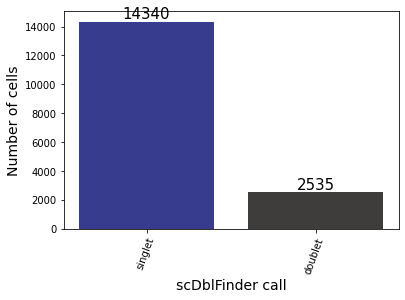

In [76]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.scdblfinder.value_counts().values, ax = ax,
            x = df_all_class_sample2.scdblfinder.value_counts().index.to_list(), palette=sd_palette)

labels = df_all_class_sample2.scdblfinder.value_counts().index.to_list()
values = df_all_class_sample2.scdblfinder.value_counts().values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("scDblFinder call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='scdblfinder', ylabel='MultiSeq_call'>

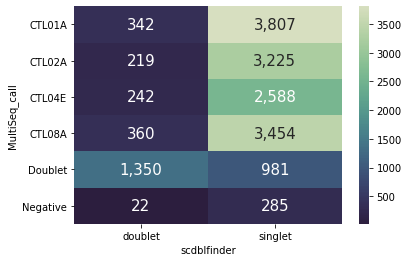

In [77]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["scdblfinder"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='scdblfinder', ylabel='CellR_call'>

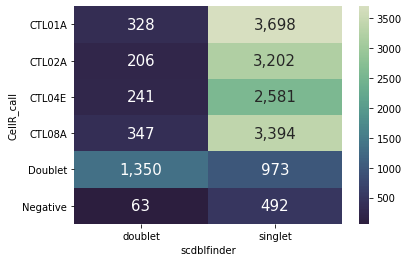

In [78]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["scdblfinder"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

### AggregatedCall

In [79]:
aggCall_sample2 = pd.read_csv(genDem_folder + "test03/aggregatedCall/aggregatedCall.tsv", sep = "\t", index_col = 0)
aggCall_sample2

,Consensus
barcode,
AAACCCAAGAGTGACC-1,3391B
AAACCCAAGCGCTGAA-1,3391B
AAACCCAAGGAACGAA-1,KOLF
AAACCCAAGGCACTAG-1,KOLF
AAACCCACAACCTAAC-1,809
...,...
TTTGTTGGTTGCTCGG-1,LowQuality
TTTGTTGTCCCGATCT-1,LowQuality
TTTGTTGTCTTCCCAG-1,LowQuality


In [80]:
aggCall_sample2["Consensus"].value_counts()

Consensus
3391B         4281
KOLF          3892
809           3807
MIFF1         3801
doublet       2900
LowQuality    1230
Name: count, dtype: int64

In [81]:
dbl_rate["Consensus"] = np.sum(aggCall_sample2["Consensus"] == "doublet") / aggCall_sample2.shape[0]
dbl_rate

{'Demuxlet': 0.2524232836120737,
 'SCanSNP': 0.08532971724172568,
 'SoC': 0.19536939380242077,
 'Vireo': 0.16302546331173723,
 'Consensus': 0.14564813419717745}

In [82]:
unassigned_rate["Consensus"] = np.sum(aggCall_sample2["Consensus"] == "LowQuality") / aggCall_sample2.shape[0]
unassigned_rate

{'Demuxlet': 0,
 'SCanSNP': 0,
 'SoC': 0.030686555170508764,
 'Vireo': 0.08658530460549445,
 'Consensus': 0.06177489829742353}

In [83]:
aggCall_sample2["Consensus"] = aggCall_sample2["Consensus"].map(old_names_map)
aggCall_sample2["Consensus"].value_counts()

Consensus
CTL01A      4281
CTL08A      3892
CTL04E      3807
CTL02A      3801
Doublet     2900
Negative    1230
Name: count, dtype: int64

In [84]:
aggCall_sample2["Consensus"].value_counts().sum()

19911

In [85]:
df_all_class_sample2 = df_all_class_sample2.merge(aggCall_sample2["Consensus"], how = "inner", left_index = True, right_index = True)

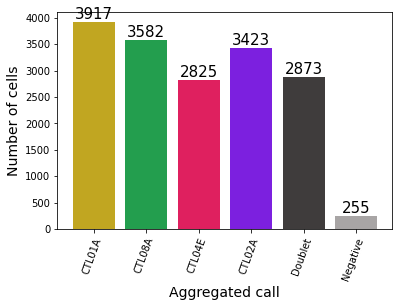

In [86]:
fig, ax = plt.subplots()

sns.barplot(y = df_all_class_sample2.Consensus.value_counts().loc[order].values, ax = ax,
            x = df_all_class_sample2.Consensus.value_counts().loc[order].index.to_list(), palette=exposures_palette)

labels = df_all_class_sample2.Consensus.value_counts().loc[order].index.to_list()
values = df_all_class_sample2.Consensus.value_counts().loc[order].values
x = np.arange(len(labels))  # the label locations
width = 0  # the width of the bars
rects = ax.bar(x, values, width)
ax.bar_label(rects, size = 15)

plt.setp(ax.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


plt.xlabel("Aggregated call", size=14)
plt.ylabel("Number of cells", size=14)
plt.show()

<AxesSubplot: xlabel='Consensus', ylabel='MultiSeq_call'>

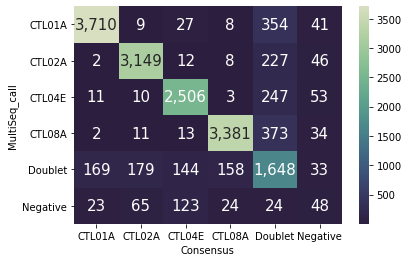

In [87]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["MultiSeq_call"], df_all_class_sample2["Consensus"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

<AxesSubplot: xlabel='Consensus', ylabel='CellR_call'>

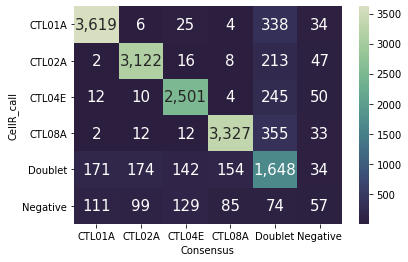

In [88]:
#plt.figure(figsize = (20,20))
sns.heatmap(pd.crosstab(df_all_class_sample2["CellR_call"], df_all_class_sample2["Consensus"]), annot=True, fmt=",d", cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True), annot_kws={"size": 15})

In [89]:
sample2_adata = sample2_adata[df_all_class_sample2.index]
sample2_adata

View of AnnData object with n_obs × n_vars = 16875 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability'
    var: 'gene_ids', 'feature_types', 'genome'

In [90]:
sample2_adata.obs = sample2_adata.obs.merge(df_all_class_sample2, right_index = True, left_index = True)
sample2_adata.obs

,Row,CMO301,CMO302,CMO303,CMO304,Multiplet,Blanks,Assignment,Assignment_Probability,MultiSeq_call,...,scansnp_call,scansnp_call_quality,Quality,scansnp_w_neg,scansnp_call_lowquality,souporcell_call,vireo_call,dropkick_label_03,scdblfinder,Consensus
AAACCCAAGAGTGACC-1,0,9.999935e-01,1.779721e-11,2.950296e-11,1.428182e-17,6.350382e-06,1.440066e-07,CTL01A,0.999994,CTL01A,...,CTL01A,CTL01A_LowQuality,LowQuality,Negative,CTL01A_LowQuality,CTL01A,Negative,LowQuality,singlet,CTL01A
AAACCCAAGCGCTGAA-1,1,9.999959e-01,3.114349e-13,8.816488e-12,1.162880e-17,4.100907e-06,4.303406e-08,CTL01A,0.999996,CTL01A,...,CTL01A,CTL01A_GoodQuality,GoodQuality,CTL01A,CTL01A_GoodQuality,CTL01A,CTL01A,LowQuality,singlet,CTL01A
AAACCCAAGGAACGAA-1,2,1.761102e-13,5.432238e-17,1.257945e-16,9.989698e-01,1.030235e-03,3.304961e-12,CTL08A,0.998970,CTL08A,...,CTL08A,CTL08A_GoodQuality,GoodQuality,CTL08A,CTL08A_GoodQuality,CTL08A,CTL08A,GoodQuality,singlet,CTL08A
AAACCCAAGGCACTAG-1,3,1.303373e-20,1.659016e-18,3.766036e-17,9.999998e-01,2.034306e-07,3.738140e-12,CTL08A,1.000000,CTL08A,...,CTL08A,CTL08A_GoodQuality,GoodQuality,CTL08A,CTL08A_GoodQuality,CTL08A,CTL08A,GoodQuality,singlet,CTL08A
AAACCCAAGGGTGAAA-1,4,3.318327e-20,6.775565e-06,1.920605e-07,1.709572e-23,9.999930e-01,2.515986e-14,Doublet,0.999993,Doublet,...,Doublet,Doublet_Doublet,Doublet,Doublet,Doublet_Doublet,Doublet,Doublet,GoodQuality,doublet,Doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGAACGAGGAATGTT-1,18871,4.597993e-08,2.722553e-07,9.899465e-01,2.543578e-14,6.059016e-07,1.005262e-02,CTL04E,0.989946,CTL04E,...,CTL04E,CTL04E_GoodQuality,GoodQuality,CTL04E,CTL04E_GoodQuality,CTL04E,Negative,LowQuality,singlet,CTL04E
TTGGATGTCCGTGCGA-1,19057,8.875275e-10,7.596057e-10,4.266601e-08,9.957648e-01,2.014455e-07,4.234997e-03,CTL08A,0.995765,CTL08A,...,CTL08A,CTL08A_GoodQuality,GoodQuality,CTL08A,CTL08A_GoodQuality,Doublet,Negative,LowQuality,singlet,CTL08A
TTTCCTCGTGGGAGAG-1,19404,6.542387e-07,9.958180e-01,1.483926e-05,1.035793e-14,7.286939e-05,4.093618e-03,CTL02A,0.995818,CTL02A,...,CTL02A,CTL02A_GoodQuality,GoodQuality,CTL02A,CTL02A_GoodQuality,Negative,CTL02A,LowQuality,singlet,CTL02A
AGCTCAAGTTGTGCAT-1,2690,5.670032e-18,5.817482e-13,9.823241e-02,2.686560e-01,6.323047e-01,8.069494e-04,Negative,0.632305,Negative,...,CTL08A,CTL08A_LowQuality,LowQuality,Negative,CTL08A_LowQuality,Doublet,Doublet,GoodQuality,doublet,Negative


# Save outputs

In [91]:
#sample2_adata.obs["MultiSeq_call_vs_CellR_call"] = sample2_adata.obs["MultiSeq_call_vs_CellR_call"].astype("str")

In [92]:
sample2_adata

AnnData object with n_obs × n_vars = 16875 × 36601
    obs: 'Row', 'CMO301', 'CMO302', 'CMO303', 'CMO304', 'Multiplet', 'Blanks', 'Assignment', 'Assignment_Probability', 'MultiSeq_call', 'CellR_call', 'demux_v1_call', 'demux_v2_call', 'scansnp_call', 'scansnp_call_quality', 'Quality', 'scansnp_w_neg', 'scansnp_call_lowquality', 'souporcell_call', 'vireo_call', 'dropkick_label_03', 'scdblfinder', 'Consensus'
    var: 'gene_ids', 'feature_types', 'genome'

In [93]:
sample2_adata.write(homeDir+"/data/cellplexDS/adatas/sample2_withClass.h5ad")

In [94]:
df_all_class_sample2.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/sample2_allCalls.csv")

# Accuracy before filtering for neg and doublets

## Precision of genetic demultiplexing tools vs Genetic Consensus, MultiSeq and Cell Ranger classifications

The precision is the ratio `tp / (tp + fp)`

### Testing against MultiSeq call:

In [95]:
precision = {}
sub_precision = df_all_class_sample2
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")

In [96]:
precision_df = pd.DataFrame(precision, index = ["MultiSeq"])
precision_df

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq,0.850631,0.888569,0.883987,0.923106,0.865385


In [97]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = df_all_class_sample2[~df_all_class_sample2[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq"])
precision_df2.columns = precision_df2.columns + "_no_neg_doub"

precision_df2

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
MultiSeq,0.857359,0.86331,0.860528,0.88874,0.868038


In [98]:
precision_df = pd.concat([precision_df.T,precision_df2.T])
precision_df

,MultiSeq
demux_v2_call,0.850631
souporcell_call,0.888569
vireo_call,0.883987
scansnp_w_neg,0.923106
Consensus,0.865385
demux_v2_call_no_neg_doub,0.857359
souporcell_call_no_neg_doub,0.863310
vireo_call_no_neg_doub,0.860528
scansnp_w_neg_no_neg_doub,0.888740
Consensus_no_neg_doub,0.868038


Removing Negative cells from Multi Seq call:

In [99]:
sub_precision = df_all_class_sample2
sub_precision = sub_precision[~sub_precision["MultiSeq_call"].isin(["Negative"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")

In [100]:
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq_no_negative"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative,0.879076,0.915358,0.910601,0.946044,0.892078


In [101]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["MultiSeq_no_negative"])
precision_df3.columns = precision_df3.columns + "_no_neg_doub"

In [102]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,MultiSeq_no_negative
demux_v2_call,0.879076
souporcell_call,0.915358
vireo_call,0.910601
scansnp_w_neg,0.946044
Consensus,0.892078
demux_v2_call_no_neg_doub,0.875791
souporcell_call_no_neg_doub,0.904695
vireo_call_no_neg_doub,0.912075
scansnp_w_neg_no_neg_doub,0.923638
Consensus_no_neg_doub,0.927741


In [103]:
precision_df = precision_df.merge( precision_df2, left_index = True, right_index = True, how = "outer")
precision_df

,MultiSeq,MultiSeq_no_negative
demux_v2_call,0.850631,0.879076
souporcell_call,0.888569,0.915358
vireo_call,0.883987,0.910601
scansnp_w_neg,0.923106,0.946044
Consensus,0.865385,0.892078
demux_v2_call_no_neg_doub,0.857359,0.875791
souporcell_call_no_neg_doub,0.863310,0.904695
vireo_call_no_neg_doub,0.860528,0.912075
scansnp_w_neg_no_neg_doub,0.888740,0.923638
Consensus_no_neg_doub,0.868038,0.927741


Removing doublet cells from Multi Seq call:

In [104]:
sub_precision = df_all_class_sample2
sub_precision = sub_precision[~sub_precision["MultiSeq_call"].isin(["Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq_no_doublet"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_doublet,0.962415,0.969516,0.970917,0.970052,0.957634


In [105]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["MultiSeq_no_doublet"])
precision_df3.columns = precision_df3.columns + "_no_neg_doub"

In [106]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,MultiSeq_no_doublet
demux_v2_call,0.962415
souporcell_call,0.969516
vireo_call,0.970917
scansnp_w_neg,0.970052
Consensus,0.957634
demux_v2_call_no_neg_doub,0.972083
souporcell_call_no_neg_doub,0.979617
vireo_call_no_neg_doub,0.983292
scansnp_w_neg_no_neg_doub,0.983966
Consensus_no_neg_doub,0.984031


In [107]:
precision_df = precision_df.merge( precision_df2, left_index = True, right_index = True, how = "outer")
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet
demux_v2_call,0.850631,0.879076,0.962415
souporcell_call,0.888569,0.915358,0.969516
vireo_call,0.883987,0.910601,0.970917
scansnp_w_neg,0.923106,0.946044,0.970052
Consensus,0.865385,0.892078,0.957634
demux_v2_call_no_neg_doub,0.857359,0.875791,0.972083
souporcell_call_no_neg_doub,0.863310,0.904695,0.979617
vireo_call_no_neg_doub,0.860528,0.912075,0.983292
scansnp_w_neg_no_neg_doub,0.888740,0.923638,0.983966
Consensus_no_neg_doub,0.868038,0.927741,0.984031


Removing both Negative and Doublet:

In [108]:
sub_precision = df_all_class_sample2
sub_precision = sub_precision[~sub_precision["MultiSeq_call"].isin(["Negative", "Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["MultiSeq_no_negative_no_doublet"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative_no_doublet,0.994358,0.996489,0.998153,0.996964,0.991006


In [109]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["MultiSeq_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["MultiSeq_no_negative_no_doublet"])
precision_df3.columns = precision_df3.columns + "_no_neg_doub"

In [110]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,MultiSeq_no_negative_no_doublet
demux_v2_call,0.994358
souporcell_call,0.996489
vireo_call,0.998153
scansnp_w_neg,0.996964
Consensus,0.991006
demux_v2_call_no_neg_doub,0.994410
souporcell_call_no_neg_doub,0.998294
vireo_call_no_neg_doub,0.999131
scansnp_w_neg_no_neg_doub,0.999202
Consensus_no_neg_doub,0.999303


In [111]:
precision_df = precision_df.merge( precision_df2, left_index = True, right_index = True, how = "outer")
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet
demux_v2_call,0.850631,0.879076,0.962415,0.994358
souporcell_call,0.888569,0.915358,0.969516,0.996489
vireo_call,0.883987,0.910601,0.970917,0.998153
scansnp_w_neg,0.923106,0.946044,0.970052,0.996964
Consensus,0.865385,0.892078,0.957634,0.991006
demux_v2_call_no_neg_doub,0.857359,0.875791,0.972083,0.994410
souporcell_call_no_neg_doub,0.863310,0.904695,0.979617,0.998294
vireo_call_no_neg_doub,0.860528,0.912075,0.983292,0.999131
scansnp_w_neg_no_neg_doub,0.888740,0.923638,0.983966,0.999202
Consensus_no_neg_doub,0.868038,0.927741,0.984031,0.999303


### Testing against CellRanger multi output

In [112]:
sub_precision = df_all_class_sample2
#sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["nan"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger"])

precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = df_all_class_sample2[~df_all_class_sample2[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger,0.833322,0.838827,0.83704,0.864831,0.843724


In [113]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger
demux_v2_call,0.826320
souporcell_call,0.866762
vireo_call,0.862517
scansnp_w_neg,0.901779
Consensus,0.844896
demux_v2_call_no_neg_doub,0.833322
souporcell_call_no_neg_doub,0.838827
vireo_call_no_neg_doub,0.837040
scansnp_w_neg_no_neg_doub,0.864831
Consensus_no_neg_doub,0.843724


In [114]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger
demux_v2_call,0.850631,0.879076,0.962415,0.994358,0.826320
souporcell_call,0.888569,0.915358,0.969516,0.996489,0.866762
vireo_call,0.883987,0.910601,0.970917,0.998153,0.862517
scansnp_w_neg,0.923106,0.946044,0.970052,0.996964,0.901779
Consensus,0.865385,0.892078,0.957634,0.991006,0.844896
demux_v2_call_no_neg_doub,0.857359,0.875791,0.972083,0.994410,0.833322
souporcell_call_no_neg_doub,0.863310,0.904695,0.979617,0.998294,0.838827
vireo_call_no_neg_doub,0.860528,0.912075,0.983292,0.999131,0.837040
scansnp_w_neg_no_neg_doub,0.888740,0.923638,0.983966,0.999202,0.864831
Consensus_no_neg_doub,0.868038,0.927741,0.984031,0.999303,0.843724


Removing Negative cells from CellRanger call:

In [115]:
sub_precision = df_all_class_sample2
sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["Negative"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger_no_negative"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative,0.879829,0.917758,0.912691,0.948377,0.893006


In [116]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger_no_negative"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative,0.875197,0.904551,0.911803,0.923391,0.927389


In [117]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger_no_negative
demux_v2_call,0.879829
souporcell_call,0.917758
vireo_call,0.912691
scansnp_w_neg,0.948377
Consensus,0.893006
demux_v2_call_no_neg_doub,0.875197
souporcell_call_no_neg_doub,0.904551
vireo_call_no_neg_doub,0.911803
scansnp_w_neg_no_neg_doub,0.923391
Consensus_no_neg_doub,0.927389


In [118]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative
demux_v2_call,0.850631,0.879076,0.962415,0.994358,0.826320,0.879829
souporcell_call,0.888569,0.915358,0.969516,0.996489,0.866762,0.917758
vireo_call,0.883987,0.910601,0.970917,0.998153,0.862517,0.912691
scansnp_w_neg,0.923106,0.946044,0.970052,0.996964,0.901779,0.948377
Consensus,0.865385,0.892078,0.957634,0.991006,0.844896,0.893006
demux_v2_call_no_neg_doub,0.857359,0.875791,0.972083,0.994410,0.833322,0.875197
souporcell_call_no_neg_doub,0.863310,0.904695,0.979617,0.998294,0.838827,0.904551
vireo_call_no_neg_doub,0.860528,0.912075,0.983292,0.999131,0.837040,0.911803
scansnp_w_neg_no_neg_doub,0.888740,0.923638,0.983966,0.999202,0.864831,0.923391
Consensus_no_neg_doub,0.868038,0.927741,0.984031,0.999303,0.843724,0.927389


Removing doublet cells from CellRanger call:

In [119]:
sub_precision = df_all_class_sample2
sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger_no_doublet"])

precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger_no_doublet"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_doublet,0.943872,0.951882,0.956506,0.957503,0.957967


In [120]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger_no_doublet
demux_v2_call,0.931810
souporcell_call,0.942199
vireo_call,0.944095
scansnp_w_neg,0.943927
Consensus,0.932434
demux_v2_call_no_neg_doub,0.943872
souporcell_call_no_neg_doub,0.951882
vireo_call_no_neg_doub,0.956506
scansnp_w_neg_no_neg_doub,0.957503
Consensus_no_neg_doub,0.957967


In [121]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet
demux_v2_call,0.850631,0.879076,0.962415,0.994358,0.826320,0.879829,0.931810
souporcell_call,0.888569,0.915358,0.969516,0.996489,0.866762,0.917758,0.942199
vireo_call,0.883987,0.910601,0.970917,0.998153,0.862517,0.912691,0.944095
scansnp_w_neg,0.923106,0.946044,0.970052,0.996964,0.901779,0.948377,0.943927
Consensus,0.865385,0.892078,0.957634,0.991006,0.844896,0.893006,0.932434
demux_v2_call_no_neg_doub,0.857359,0.875791,0.972083,0.994410,0.833322,0.875197,0.943872
souporcell_call_no_neg_doub,0.863310,0.904695,0.979617,0.998294,0.838827,0.904551,0.951882
vireo_call_no_neg_doub,0.860528,0.912075,0.983292,0.999131,0.837040,0.911803,0.956506
scansnp_w_neg_no_neg_doub,0.888740,0.923638,0.983966,0.999202,0.864831,0.923391,0.957503
Consensus_no_neg_doub,0.868038,0.927741,0.984031,0.999303,0.843724,0.927389,0.957967


Removing both Negative and Doublet:

In [122]:
sub_precision = df_all_class_sample2
sub_precision = sub_precision[~sub_precision["CellR_call"].isin(["Negative", "Doublet"])]
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df2 = pd.DataFrame(precision, index = ["CellRanger_no_negative_no_doublet"])
precision_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative_no_doublet,0.994427,0.99643,0.998269,0.996836,0.991107


In [123]:
precision = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_precision = sub_precision[~sub_precision[s].isin(["Negative", "Doublet"])]
    precision[s] = skm.precision_score(y_true = sub_precision["CellR_call"],
                      y_pred =  sub_precision[s], average="weighted")
    
precision_df3 = pd.DataFrame(precision, index = ["CellRanger_no_negative_no_doublet"])
precision_df3.columns = precision_df2.columns + "_no_neg_doub"
precision_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative_no_doublet,0.994482,0.998271,0.999119,0.999191,0.999205


In [124]:
precision_df2 = pd.concat([precision_df2.T,precision_df3.T])
precision_df2

,CellRanger_no_negative_no_doublet
demux_v2_call,0.994427
souporcell_call,0.996430
vireo_call,0.998269
scansnp_w_neg,0.996836
Consensus,0.991107
demux_v2_call_no_neg_doub,0.994482
souporcell_call_no_neg_doub,0.998271
vireo_call_no_neg_doub,0.999119
scansnp_w_neg_no_neg_doub,0.999191
Consensus_no_neg_doub,0.999205


In [125]:
precision_df = precision_df.merge(precision_df2, left_index=True, right_index=True)
precision_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet,CellRanger_no_negative_no_doublet
demux_v2_call,0.850631,0.879076,0.962415,0.994358,0.826320,0.879829,0.931810,0.994427
souporcell_call,0.888569,0.915358,0.969516,0.996489,0.866762,0.917758,0.942199,0.996430
vireo_call,0.883987,0.910601,0.970917,0.998153,0.862517,0.912691,0.944095,0.998269
scansnp_w_neg,0.923106,0.946044,0.970052,0.996964,0.901779,0.948377,0.943927,0.996836
Consensus,0.865385,0.892078,0.957634,0.991006,0.844896,0.893006,0.932434,0.991107
demux_v2_call_no_neg_doub,0.857359,0.875791,0.972083,0.994410,0.833322,0.875197,0.943872,0.994482
souporcell_call_no_neg_doub,0.863310,0.904695,0.979617,0.998294,0.838827,0.904551,0.951882,0.998271
vireo_call_no_neg_doub,0.860528,0.912075,0.983292,0.999131,0.837040,0.911803,0.956506,0.999119
scansnp_w_neg_no_neg_doub,0.888740,0.923638,0.983966,0.999202,0.864831,0.923391,0.957503,0.999191
Consensus_no_neg_doub,0.868038,0.927741,0.984031,0.999303,0.843724,0.927389,0.957967,0.999205


In [126]:
precision_df.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/precision_sample2.csv")

## Recall of genetic demultiplexing tools vs Genetic Consensus, MultiSeq and Cell Ranger classifications

### Testing against MultiSeq call:

In [127]:
recall = {}
sub_recall = df_all_class_sample2
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df = pd.DataFrame(recall, index = ["MultiSeq"])
recall_df

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq,0.854696,0.899319,0.88,0.889719,0.855822


In [128]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = df_all_class_sample2[~df_all_class_sample2[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq"])
recall_df2.columns = recall_df2.columns + "_no_neg_doub"
recall_df2

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
MultiSeq,0.923198,0.927279,0.926654,0.941147,0.927184


In [129]:
recall_df = pd.concat([recall_df.T,recall_df2.T])
recall_df

,MultiSeq
demux_v2_call,0.854696
souporcell_call,0.899319
vireo_call,0.880000
scansnp_w_neg,0.889719
Consensus,0.855822
demux_v2_call_no_neg_doub,0.923198
souporcell_call_no_neg_doub,0.927279
vireo_call_no_neg_doub,0.926654
scansnp_w_neg_no_neg_doub,0.941147
Consensus_no_neg_doub,0.927184


Removing Negative cells from Multi Seq call:

In [130]:
sub_recall = df_all_class_sample2
sub_recall = sub_recall[~sub_recall["MultiSeq_call"].isin(["Negative"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq_no_negative"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative,0.870534,0.914051,0.892021,0.896668,0.868783


In [131]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["MultiSeq_no_negative"])
recall_df3.columns = recall_df3.columns + "_no_neg_doub"
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,MultiSeq_no_negative
demux_v2_call,0.870534
souporcell_call,0.914051
vireo_call,0.892021
scansnp_w_neg,0.896668
Consensus,0.868783
demux_v2_call_no_neg_doub,0.933180
souporcell_call_no_neg_doub,0.950314
vireo_call_no_neg_doub,0.954590
scansnp_w_neg_no_neg_doub,0.960658
Consensus_no_neg_doub,0.962845


In [132]:
recall_df = recall_df.merge( recall_df2, left_index = True, right_index = True, how = "outer")
recall_df

,MultiSeq,MultiSeq_no_negative
demux_v2_call,0.854696,0.870534
souporcell_call,0.899319,0.914051
vireo_call,0.880000,0.892021
scansnp_w_neg,0.889719,0.896668
Consensus,0.855822,0.868783
demux_v2_call_no_neg_doub,0.923198,0.933180
souporcell_call_no_neg_doub,0.927279,0.950314
vireo_call_no_neg_doub,0.926654,0.954590
scansnp_w_neg_no_neg_doub,0.941147,0.960658
Consensus_no_neg_doub,0.927184,0.962845


Removing doublet cells from Multi Seq call:

In [133]:
sub_recall = df_all_class_sample2
sub_recall = sub_recall[~sub_recall["MultiSeq_call"].isin(["Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq_no_doublet"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_doublet,0.890127,0.942932,0.925674,0.926774,0.879675


In [134]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["MultiSeq_no_doublet"])
recall_df3.columns = recall_df3.columns + "_no_neg_doub"
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,MultiSeq_no_doublet
demux_v2_call,0.890127
souporcell_call,0.942932
vireo_call,0.925674
scansnp_w_neg,0.926774
Consensus,0.879675
demux_v2_call_no_neg_doub,0.983066
souporcell_call_no_neg_doub,0.988844
vireo_call_no_neg_doub,0.991135
scansnp_w_neg_no_neg_doub,0.991514
Consensus_no_neg_doub,0.991602


In [135]:
recall_df = recall_df.merge( recall_df2, left_index = True, right_index = True, how = "outer")
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet
demux_v2_call,0.854696,0.870534,0.890127
souporcell_call,0.899319,0.914051,0.942932
vireo_call,0.880000,0.892021,0.925674
scansnp_w_neg,0.889719,0.896668,0.926774
Consensus,0.855822,0.868783,0.879675
demux_v2_call_no_neg_doub,0.923198,0.933180,0.983066
souporcell_call_no_neg_doub,0.927279,0.950314,0.988844
vireo_call_no_neg_doub,0.926654,0.954590,0.991135
scansnp_w_neg_no_neg_doub,0.941147,0.960658,0.991514
Consensus_no_neg_doub,0.927184,0.962845,0.991602


Removing both Negative and Doublet:

In [136]:
sub_recall = df_all_class_sample2
sub_recall = sub_recall[~sub_recall["MultiSeq_call"].isin(["Negative", "Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["MultiSeq_no_negative_no_doublet"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
MultiSeq_no_negative_no_doublet,0.909321,0.961017,0.940648,0.935661,0.895273


In [137]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["MultiSeq_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["MultiSeq_no_negative_no_doublet"])
recall_df3.columns = recall_df3.columns + "_no_neg_doub"
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,MultiSeq_no_negative_no_doublet
demux_v2_call,0.909321
souporcell_call,0.961017
vireo_call,0.940648
scansnp_w_neg,0.935661
Consensus,0.895273
demux_v2_call_no_neg_doub,0.994393
souporcell_call_no_neg_doub,0.998291
vireo_call_no_neg_doub,0.999130
scansnp_w_neg_no_neg_doub,0.999201
Consensus_no_neg_doub,0.999302


In [138]:
recall_df = recall_df.merge( recall_df2, left_index = True, right_index = True, how = "outer")
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet
demux_v2_call,0.854696,0.870534,0.890127,0.909321
souporcell_call,0.899319,0.914051,0.942932,0.961017
vireo_call,0.880000,0.892021,0.925674,0.940648
scansnp_w_neg,0.889719,0.896668,0.926774,0.935661
Consensus,0.855822,0.868783,0.879675,0.895273
demux_v2_call_no_neg_doub,0.923198,0.933180,0.983066,0.994393
souporcell_call_no_neg_doub,0.927279,0.950314,0.988844,0.998291
vireo_call_no_neg_doub,0.926654,0.954590,0.991135,0.999130
scansnp_w_neg_no_neg_doub,0.941147,0.960658,0.991514,0.999201
Consensus_no_neg_doub,0.927184,0.962845,0.991602,0.999302


### Testing against CellRanger multi output

In [139]:
sub_recall = df_all_class_sample2
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["CellRanger"])
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = df_all_class_sample2[~df_all_class_sample2[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
recall_df3 = pd.DataFrame(recall, index = ["CellRanger"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger,0.91029,0.914131,0.91406,0.92843,0.914309


In [140]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger
demux_v2_call,0.843911
souporcell_call,0.887644
vireo_call,0.869748
scansnp_w_neg,0.880889
Consensus,0.845867
demux_v2_call_no_neg_doub,0.910290
souporcell_call_no_neg_doub,0.914131
vireo_call_no_neg_doub,0.914060
scansnp_w_neg_no_neg_doub,0.928430
Consensus_no_neg_doub,0.914309


In [141]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger
demux_v2_call,0.854696,0.870534,0.890127,0.909321,0.843911
souporcell_call,0.899319,0.914051,0.942932,0.961017,0.887644
vireo_call,0.880000,0.892021,0.925674,0.940648,0.869748
scansnp_w_neg,0.889719,0.896668,0.926774,0.935661,0.880889
Consensus,0.855822,0.868783,0.879675,0.895273,0.845867
demux_v2_call_no_neg_doub,0.923198,0.933180,0.983066,0.994393,0.910290
souporcell_call_no_neg_doub,0.927279,0.950314,0.988844,0.998291,0.914131
vireo_call_no_neg_doub,0.926654,0.954590,0.991135,0.999130,0.914060
scansnp_w_neg_no_neg_doub,0.941147,0.960658,0.991514,0.999201,0.928430
Consensus_no_neg_doub,0.927184,0.962845,0.991602,0.999302,0.914309


Removing Negative cells from CellRanger call:

In [142]:
sub_recall = df_all_class_sample2
sub_recall = sub_recall[~sub_recall["CellR_call"].isin(["Negative"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["CellRanger_no_negative"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative,0.87261,0.916054,0.894301,0.899326,0.87114


In [143]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["CellRanger_no_negative"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative,0.932909,0.950232,0.954448,0.960529,0.962619


In [144]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger_no_negative
demux_v2_call,0.872610
souporcell_call,0.916054
vireo_call,0.894301
scansnp_w_neg,0.899326
Consensus,0.871140
demux_v2_call_no_neg_doub,0.932909
souporcell_call_no_neg_doub,0.950232
vireo_call_no_neg_doub,0.954448
scansnp_w_neg_no_neg_doub,0.960529
Consensus_no_neg_doub,0.962619


In [145]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative
demux_v2_call,0.854696,0.870534,0.890127,0.909321,0.843911,0.872610
souporcell_call,0.899319,0.914051,0.942932,0.961017,0.887644,0.916054
vireo_call,0.880000,0.892021,0.925674,0.940648,0.869748,0.894301
scansnp_w_neg,0.889719,0.896668,0.926774,0.935661,0.880889,0.899326
Consensus,0.855822,0.868783,0.879675,0.895273,0.845867,0.871140
demux_v2_call_no_neg_doub,0.923198,0.933180,0.983066,0.994393,0.910290,0.932909
souporcell_call_no_neg_doub,0.927279,0.950314,0.988844,0.998291,0.914131,0.950232
vireo_call_no_neg_doub,0.926654,0.954590,0.991135,0.999130,0.914060,0.954448
scansnp_w_neg_no_neg_doub,0.941147,0.960658,0.991514,0.999201,0.928430,0.960529
Consensus_no_neg_doub,0.927184,0.962845,0.991602,0.999302,0.914309,0.962619


Removing doublet cells from CellRanger call:

In [146]:
sub_recall = df_all_class_sample2
sub_recall = sub_recall[~sub_recall["CellR_call"].isin(["Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df2 = pd.DataFrame(recall, index = ["CellRanger_no_doublet"])
recall = {}

for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["CellRanger_no_doublet"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_doublet,0.968807,0.974781,0.977574,0.97812,0.978364


In [147]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger_no_doublet
demux_v2_call,0.877199
souporcell_call,0.928876
vireo_call,0.913414
scansnp_w_neg,0.915957
Consensus,0.867647
demux_v2_call_no_neg_doub,0.968807
souporcell_call_no_neg_doub,0.974781
vireo_call_no_neg_doub,0.977574
scansnp_w_neg_no_neg_doub,0.978120
Consensus_no_neg_doub,0.978364


In [148]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet
demux_v2_call,0.854696,0.870534,0.890127,0.909321,0.843911,0.872610,0.877199
souporcell_call,0.899319,0.914051,0.942932,0.961017,0.887644,0.916054,0.928876
vireo_call,0.880000,0.892021,0.925674,0.940648,0.869748,0.894301,0.913414
scansnp_w_neg,0.889719,0.896668,0.926774,0.935661,0.880889,0.899326,0.915957
Consensus,0.855822,0.868783,0.879675,0.895273,0.845867,0.871140,0.867647
demux_v2_call_no_neg_doub,0.923198,0.933180,0.983066,0.994393,0.910290,0.932909,0.968807
souporcell_call_no_neg_doub,0.927279,0.950314,0.988844,0.998291,0.914131,0.950232,0.974781
vireo_call_no_neg_doub,0.926654,0.954590,0.991135,0.999130,0.914060,0.954448,0.977574
scansnp_w_neg_no_neg_doub,0.941147,0.960658,0.991514,0.999201,0.928430,0.960529,0.978120
Consensus_no_neg_doub,0.927184,0.962845,0.991602,0.999302,0.914309,0.962619,0.978364


Removing both Negative and Doublet:

In [149]:
sub_recall = df_all_class_sample2
sub_recall = sub_recall[~sub_recall["CellR_call"].isin(["Negative", "Doublet"])]
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
recall_df2 = pd.DataFrame(recall, index = ["CellRanger_no_negative_no_doublet"])
recall_df2

,demux_v2_call,souporcell_call,vireo_call,scansnp_w_neg,Consensus
CellRanger_no_negative_no_doublet,0.911981,0.963635,0.943774,0.938844,0.897978


In [150]:
recall = {}
for s in ["demux_v2_call", "souporcell_call", "vireo_call", "scansnp_w_neg", "Consensus"]:
    sub_recall = sub_recall[~sub_recall[s].isin(["Negative", "Doublet"])]
    recall[s] = skm.recall_score(y_true = sub_recall["CellR_call"],
                      y_pred =  sub_recall[s], average="weighted")
    
recall_df3 = pd.DataFrame(recall, index = ["CellRanger_no_negative_no_doublet"])
recall_df3.columns = recall_df2.columns + "_no_neg_doub"
recall_df3

,demux_v2_call_no_neg_doub,souporcell_call_no_neg_doub,vireo_call_no_neg_doub,scansnp_w_neg_no_neg_doub,Consensus_no_neg_doub
CellRanger_no_negative_no_doublet,0.994469,0.998268,0.999118,0.99919,0.999205


In [151]:
recall_df2 = pd.concat([recall_df2.T,recall_df3.T])
recall_df2

,CellRanger_no_negative_no_doublet
demux_v2_call,0.911981
souporcell_call,0.963635
vireo_call,0.943774
scansnp_w_neg,0.938844
Consensus,0.897978
demux_v2_call_no_neg_doub,0.994469
souporcell_call_no_neg_doub,0.998268
vireo_call_no_neg_doub,0.999118
scansnp_w_neg_no_neg_doub,0.999190
Consensus_no_neg_doub,0.999205


In [152]:
recall_df = recall_df.merge(recall_df2, left_index=True, right_index=True)
recall_df

,MultiSeq,MultiSeq_no_negative,MultiSeq_no_doublet,MultiSeq_no_negative_no_doublet,CellRanger,CellRanger_no_negative,CellRanger_no_doublet,CellRanger_no_negative_no_doublet
demux_v2_call,0.854696,0.870534,0.890127,0.909321,0.843911,0.872610,0.877199,0.911981
souporcell_call,0.899319,0.914051,0.942932,0.961017,0.887644,0.916054,0.928876,0.963635
vireo_call,0.880000,0.892021,0.925674,0.940648,0.869748,0.894301,0.913414,0.943774
scansnp_w_neg,0.889719,0.896668,0.926774,0.935661,0.880889,0.899326,0.915957,0.938844
Consensus,0.855822,0.868783,0.879675,0.895273,0.845867,0.871140,0.867647,0.897978
demux_v2_call_no_neg_doub,0.923198,0.933180,0.983066,0.994393,0.910290,0.932909,0.968807,0.994469
souporcell_call_no_neg_doub,0.927279,0.950314,0.988844,0.998291,0.914131,0.950232,0.974781,0.998268
vireo_call_no_neg_doub,0.926654,0.954590,0.991135,0.999130,0.914060,0.954448,0.977574,0.999118
scansnp_w_neg_no_neg_doub,0.941147,0.960658,0.991514,0.999201,0.928430,0.960529,0.978120,0.999190
Consensus_no_neg_doub,0.927184,0.962845,0.991602,0.999302,0.914309,0.962619,0.978364,0.999205


In [153]:
recall_df.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/recall_sample2.csv")

# Save

In [154]:
dbl_rate_df = pd.DataFrame(dbl_rate.items())
dbl_rate_df.columns = ["Software", "Doublet_Rate"]
dbl_rate_df["Unassigned_rate"] = unassigned_rate.values()

In [155]:
dbl_rate_df.to_csv(homeDir+"/data/cellplexDS/CellplexOuts/sample2_DoubletSinglet_rates.csv")